# 21 - Boost Medio: Fixed vs Variable + Estresse

Este notebook compara o **mesmo conversor em modelo medio** com:
- `fixed step`
- `variable step`

E roda uma campanha de estresse para medir:
- taxa de convergencia
- tempo total
- numero de passos
- rejeicoes de passo

> Nota: aqui usamos **modelo medio (sem chaveamento explicito)** para isolar o comportamento dos modos de integracao.


In [1]:
import time
import statistics

import numpy as np
import matplotlib.pyplot as plt

import pulsim as ps

print("Pulsim:", ps.__version__)
print("Backend capabilities:", ps.backend_capabilities())


Pulsim: 0.4.1
Backend capabilities: {'klu': True, 'hypre_amg': True, 'sundials': False}


## 1) Parametros do conversor

Ajuste os parametros abaixo para deixar os casos mais leves ou mais pesados.


In [2]:
CONVERTER_ID = "boost_avg"

VIN = 18.0
DUTY = 0.55
TURNS_RATIO = 1.0
L_MAIN = 220e-6
C_MAIN = 180e-6
R_LOAD = 18.0
RC_SECTIONS = 9

# Perfil de estresse
# Se quiser acelerar para smoke test: STRESS_HEAVY = False
STRESS_HEAVY = True

BASE_TSTOP = 0.020 if STRESS_HEAVY else 0.006
BASE_DT_FIXED = 5e-7 if STRESS_HEAVY else 1e-6

print("Conversor:", CONVERTER_ID)
print("BASE_TSTOP:", BASE_TSTOP)
print("BASE_DT_FIXED:", BASE_DT_FIXED)


Conversor: boost_avg
BASE_TSTOP: 0.02
BASE_DT_FIXED: 5e-07


## 2) Circuito equivalente (modelo medio)

Para manter comparacao limpa entre `fixed` e `variable`, o circuito usa fonte equivalente + rede passiva de alta ordem.


In [3]:
def equivalent_output_voltage(vin: float, duty: float, turns_ratio: float = 1.0) -> float:
    duty = float(np.clip(duty, 1e-4, 0.95))
    return vin / max(1e-4, (1.0 - duty))


def build_circuit(vin: float, duty: float, turns_ratio: float, L_main: float, C_main: float, R_load: float, rc_sections: int = 9):
    ckt = ps.Circuit()
    gnd = ckt.ground()

    n_src = ckt.add_node("src")
    n_out = ckt.add_node("out")

    v_eq = equivalent_output_voltage(vin, duty, turns_ratio)
    ckt.add_voltage_source("Veq", n_src, gnd, v_eq)

    # Dinamica principal
    ckt.add_inductor("L_main", n_src, n_out, L_main, 0.0)
    ckt.add_capacitor("C_main", n_out, gnd, C_main, 0.0)
    ckt.add_resistor("R_load", n_out, gnd, R_load)

    # Rede RC extra para aumentar ordem e rigidez numerica
    prev = n_out
    for k in range(int(rc_sections)):
        n_rc = ckt.add_node(f"rc_{k}")
        r_val = 0.12 + 0.03 * k
        c_val = 8.2e-6 / (1.0 + 0.22 * k)
        ckt.add_resistor(f"Rrc_{k}", prev, n_rc, r_val)
        ckt.add_capacitor(f"Crc_{k}", n_rc, gnd, c_val, 0.0)
        prev = n_rc

    # Carga auxiliar para evitar nos muito frouxos
    ckt.add_resistor("R_aux", prev, gnd, max(8.0, R_load * 0.8))



    return ckt, {"n_out": n_out, "v_eq": v_eq}


## 3) Configuracao de solver

Regras usadas:
- `fixed`: `BDF1`, passo fixo estrito (`dt_min == dt_max == dt`)
- `variable`: defaults de adaptacao do backend (mais estaveis para este perfil)


In [4]:
def build_options(step_mode: str, tstop: float, dt_fixed: float):
    opts = ps.SimulationOptions()
    opts.tstart = 0.0
    opts.tstop = float(tstop)
    opts.dt = float(dt_fixed)

    opts.transient_backend = ps.TransientBackendMode.Native
    opts.newton_options.max_iterations = 140
    opts.newton_options.auto_damping = True
    opts.linear_solver.allow_fallback = True
    opts.linear_solver.auto_select = True
    opts.max_step_retries = 20

    if step_mode == "fixed":
        opts.step_mode = ps.StepMode.Fixed
        opts.integrator = ps.Integrator.BDF1
        opts.dt_min = opts.dt
        opts.dt_max = opts.dt
    else:
        opts.step_mode = ps.StepMode.Variable
        # Importante: manter defaults de adaptacao para robustez.

    return opts


def signal_index(circuit: ps.Circuit, node_name: str) -> int:
    names = [n.lower() for n in circuit.signal_names()]
    target = f"v({node_name.lower()})"
    if target not in names:
        raise ValueError(f"Sinal {target} nao encontrado em {circuit.signal_names()}")
    return names.index(target)


def run_case(step_mode: str, vin: float, duty: float, turns_ratio: float, L_main: float, C_main: float, R_load: float, tstop: float, dt_fixed: float, rc_sections: int):
    ckt, meta = build_circuit(vin, duty, turns_ratio, L_main, C_main, R_load, rc_sections=rc_sections)
    opts = build_options(step_mode, tstop=tstop, dt_fixed=dt_fixed)

    sim = ps.Simulator(ckt, opts)

    t0 = time.perf_counter()
    res = sim.run_transient()
    elapsed = time.perf_counter() - t0

    out = {
        "mode": step_mode,
        "success": bool(res.success),
        "message": str(res.message),
        "elapsed_s": float(elapsed),
        "steps": int(res.total_steps),
        "rejections": int(res.timestep_rejections),
        "newton_total": int(res.newton_iterations_total),
        "v_eq": float(meta["v_eq"]),
        "time": np.asarray(res.time, dtype=float),
        "vout": np.array([], dtype=float),
    }

    if res.success and len(res.time) > 4 and len(res.states) > 4:
        idx = signal_index(ckt, "out")
        states = np.asarray(res.states, dtype=float)
        vout = states[:, idx]
        out["vout"] = vout

        tail = max(8, int(0.2 * len(vout)))
        segment = vout[-tail:]
        out["vout_final"] = float(vout[-1])
        out["vout_mean_tail"] = float(np.mean(segment))
        out["vout_ripple_tail"] = float(np.max(segment) - np.min(segment))
    else:
        out["vout_final"] = float("nan")
        out["vout_mean_tail"] = float("nan")
        out["vout_ripple_tail"] = float("nan")

    return out


## 4) Rodada base: fixed vs variable


In [5]:
base_fixed = run_case(
    step_mode="fixed",
    vin=VIN,
    duty=DUTY,
    turns_ratio=TURNS_RATIO,
    L_main=L_MAIN,
    C_main=C_MAIN,
    R_load=R_LOAD,
    tstop=BASE_TSTOP,
    dt_fixed=BASE_DT_FIXED,
    rc_sections=RC_SECTIONS,
)

base_variable = run_case(
    step_mode="variable",
    vin=VIN,
    duty=DUTY,
    turns_ratio=TURNS_RATIO,
    L_main=L_MAIN,
    C_main=C_MAIN,
    R_load=R_LOAD,
    tstop=BASE_TSTOP,
    dt_fixed=BASE_DT_FIXED,
    rc_sections=RC_SECTIONS,
)

for item in (base_fixed, base_variable):
    print("-" * 70)
    print("mode:", item["mode"])
    print("success:", item["success"])
    print("message:", item["message"])
    print("elapsed_s:", f"{item['elapsed_s']:.4f}")
    print("steps:", item["steps"], "rejections:", item["rejections"], "newton_total:", item["newton_total"])
    if item["success"]:
        print("v_eq:", f"{item['v_eq']:.3f} V")
        print("vout_final:", f"{item['vout_final']:.3f} V")
        print("vout_mean_tail:", f"{item['vout_mean_tail']:.3f} V")
        print("vout_ripple_tail:", f"{item['vout_ripple_tail']*1e3:.3f} mV")


----------------------------------------------------------------------
mode: fixed
success: True
message: Transient completed
elapsed_s: 0.1453
steps: 40000 rejections: 0 newton_total: 40000
v_eq: 40.000 V
vout_final: 40.000 V
vout_mean_tail: 40.000 V
vout_ripple_tail: 0.000 mV
----------------------------------------------------------------------
mode: variable
success: True
message: Transient completed
elapsed_s: 0.0043
steps: 431 rejections: 0 newton_total: 431
v_eq: 40.000 V
vout_final: 40.000 V
vout_mean_tail: 40.000 V
vout_ripple_tail: 0.000 mV


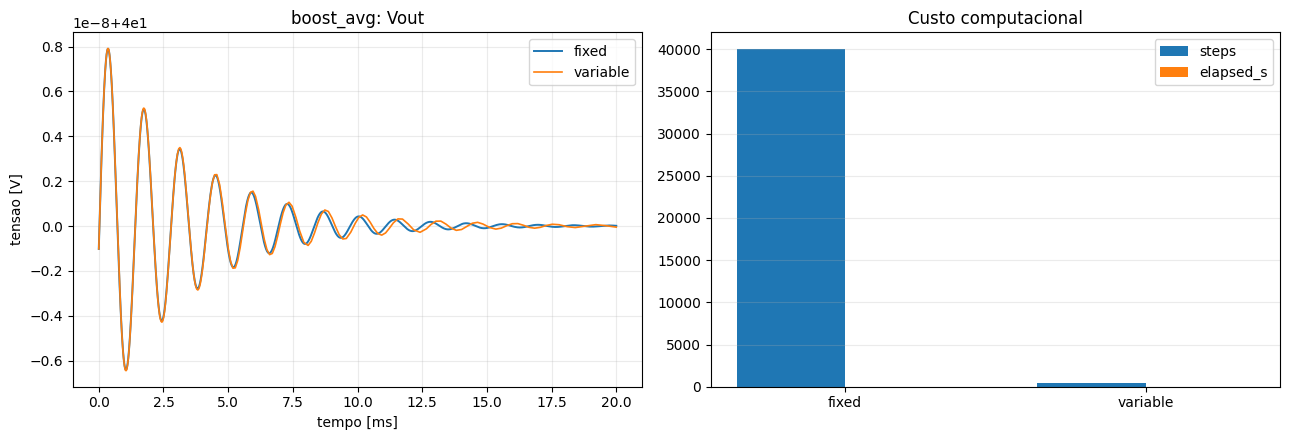

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4.5))

if base_fixed["success"]:
    ax[0].plot(base_fixed["time"] * 1e3, base_fixed["vout"], label="fixed", lw=1.4)
if base_variable["success"]:
    ax[0].plot(base_variable["time"] * 1e3, base_variable["vout"], label="variable", lw=1.2)

ax[0].set_title(f"{CONVERTER_ID}: Vout")
ax[0].set_xlabel("tempo [ms]")
ax[0].set_ylabel("tensao [V]")
ax[0].grid(True, alpha=0.25)
ax[0].legend()

labels = ["fixed", "variable"]
steps = [base_fixed["steps"], base_variable["steps"]]
elapsed = [base_fixed["elapsed_s"], base_variable["elapsed_s"]]

x = np.arange(len(labels))
bar_w = 0.36
ax[1].bar(x - bar_w/2, steps, width=bar_w, label="steps")
ax[1].bar(x + bar_w/2, elapsed, width=bar_w, label="elapsed_s")
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_title("Custo computacional")
ax[1].grid(True, axis="y", alpha=0.25)
ax[1].legend()

plt.tight_layout()
plt.show()


## 5) Campanha de estresse (pesada)

Executa varios cenarios de carga/duty/constantes de tempo para comparar convergencia e custo.


In [7]:
if STRESS_HEAVY:
    scenarios = [
        {"name": "S1", "duty_scale": 0.88, "load_scale": 0.70, "lc_scale": 0.70, "tstop_scale": 1.0},
        {"name": "S2", "duty_scale": 0.92, "load_scale": 0.85, "lc_scale": 0.85, "tstop_scale": 1.2},
        {"name": "S3", "duty_scale": 1.00, "load_scale": 1.00, "lc_scale": 1.00, "tstop_scale": 1.0},
        {"name": "S4", "duty_scale": 1.05, "load_scale": 1.20, "lc_scale": 1.10, "tstop_scale": 1.5},
        {"name": "S5", "duty_scale": 1.10, "load_scale": 1.35, "lc_scale": 1.30, "tstop_scale": 2.0},
        {"name": "S6", "duty_scale": 0.95, "load_scale": 0.60, "lc_scale": 1.20, "tstop_scale": 1.8},
    ]
else:
    scenarios = [
        {"name": "S1", "duty_scale": 1.0, "load_scale": 1.0, "lc_scale": 1.0, "tstop_scale": 1.0},
        {"name": "S2", "duty_scale": 1.05, "load_scale": 1.2, "lc_scale": 1.1, "tstop_scale": 1.2},
    ]

campaign_results = []
for sc in scenarios:
    for mode in ("fixed", "variable"):
        duty = float(np.clip(DUTY * sc["duty_scale"], 0.05, 0.90))
        rload = max(0.5, R_LOAD * sc["load_scale"])
        l_main = L_MAIN * sc["lc_scale"]
        c_main = C_MAIN * sc["lc_scale"]
        tstop = BASE_TSTOP * sc["tstop_scale"]

        result = run_case(
            step_mode=mode,
            vin=VIN,
            duty=duty,
            turns_ratio=TURNS_RATIO,
            L_main=l_main,
            C_main=c_main,
            R_load=rload,
            tstop=tstop,
            dt_fixed=BASE_DT_FIXED,
            rc_sections=RC_SECTIONS,
        )
        result["scenario"] = sc["name"]
        campaign_results.append(result)

print(f"Cenarios executados: {len(campaign_results)}")


Cenarios executados: 12


In [8]:
def summarize_mode(results, mode):
    data = [r for r in results if r["mode"] == mode]
    ok = [r for r in data if r["success"]]
    fail = [r for r in data if not r["success"]]

    success_rate = (len(ok) / max(1, len(data))) * 100.0
    med_elapsed = statistics.median([r["elapsed_s"] for r in data]) if data else float("nan")
    med_steps = statistics.median([r["steps"] for r in data]) if data else float("nan")
    med_rej = statistics.median([r["rejections"] for r in data]) if data else float("nan")

    return {
        "mode": mode,
        "n": len(data),
        "n_ok": len(ok),
        "n_fail": len(fail),
        "success_rate": success_rate,
        "median_elapsed_s": med_elapsed,
        "median_steps": med_steps,
        "median_rejections": med_rej,
    }


sum_fixed = summarize_mode(campaign_results, "fixed")
sum_variable = summarize_mode(campaign_results, "variable")

for s in (sum_fixed, sum_variable):
    print("=" * 72)
    print("mode:", s["mode"])
    print("casos:", s["n"], "ok:", s["n_ok"], "fail:", s["n_fail"], "success_rate:", f"{s['success_rate']:.1f}%")
    print("median_elapsed_s:", f"{s['median_elapsed_s']:.4f}")
    print("median_steps:", int(s["median_steps"]))
    print("median_rejections:", int(s["median_rejections"]))

if sum_fixed["n_ok"] > 0 and sum_variable["n_ok"] > 0:
    speedup = sum_fixed["median_elapsed_s"] / max(1e-12, sum_variable["median_elapsed_s"])
    step_reduction = sum_fixed["median_steps"] / max(1e-12, sum_variable["median_steps"])
    print("=" * 72)
    print(f"speedup mediano (fixed/variable): {speedup:.2f}x")
    print(f"reducao mediana de passos (fixed/variable): {step_reduction:.2f}x")


mode: fixed
casos: 6 ok: 6 fail: 0 success_rate: 100.0%
median_elapsed_s: 0.2330
median_steps: 54000
median_rejections: 0
mode: variable
casos: 6 ok: 6 fail: 0 success_rate: 100.0%
median_elapsed_s: 0.0041
median_steps: 448
median_rejections: 0
speedup mediano (fixed/variable): 57.22x
reducao mediana de passos (fixed/variable): 120.40x


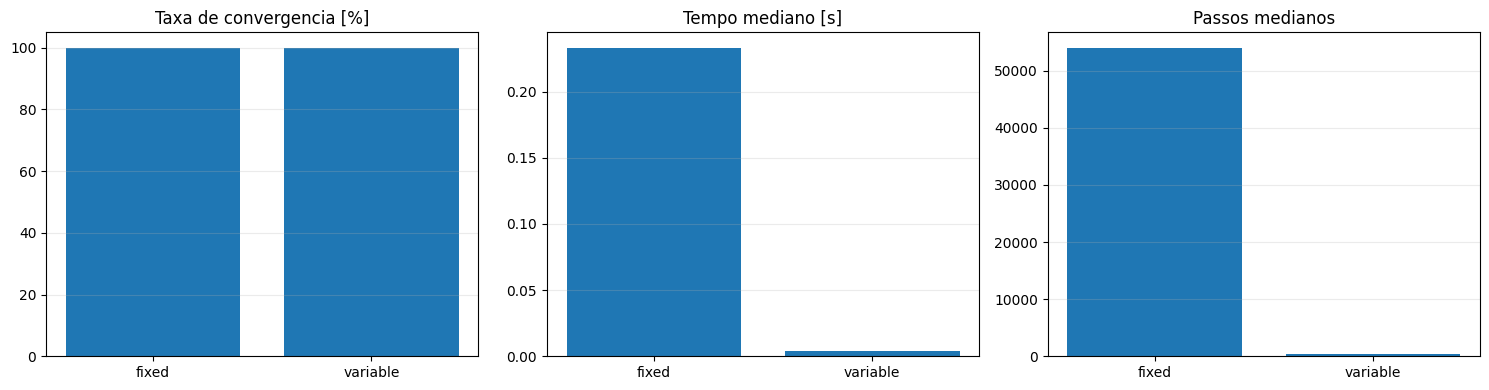

In [9]:
labels = ["fixed", "variable"]
summary = [sum_fixed, sum_variable]

success_rate = [s["success_rate"] for s in summary]
med_elapsed = [s["median_elapsed_s"] for s in summary]
med_steps = [s["median_steps"] for s in summary]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].bar(labels, success_rate)
ax[0].set_ylim([0, 105])
ax[0].set_title("Taxa de convergencia [%]")
ax[0].grid(True, axis="y", alpha=0.25)

ax[1].bar(labels, med_elapsed)
ax[1].set_title("Tempo mediano [s]")
ax[1].grid(True, axis="y", alpha=0.25)

ax[2].bar(labels, med_steps)
ax[2].set_title("Passos medianos")
ax[2].grid(True, axis="y", alpha=0.25)

plt.tight_layout()
plt.show()
